In [1]:
!make

-- Found pybind11: /home/tyler/Documents/CMU/DL-Systems-Project/.venv/lib/python3.12/site-packages/pybind11/include (found version "3.0.1")
-- Found cuda, building cuda backend
Fri Nov 21 00:10:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 64%   62C    P2            184W /  310W |    5248MiB 

In [2]:
import sys
sys.path.append('./python')

# Force reload of modules to pick up changes
import importlib
if 'needle' in sys.modules:
    # Remove all needle modules to force fresh import
    to_remove = [key for key in sys.modules.keys() if key.startswith('needle')]
    for key in to_remove:
        del sys.modules[key]

import numpy as np
import needle as ndl
from needle import backend_ndarray as nd
import time
import matplotlib.pyplot as plt

print("Needle DL Framework - Quantization Demo")
print("=" * 50)

Using needle backend
Needle DL Framework - Quantization Demo


## 1. Basic NDArray Quantization

Let's start with basic quantization of NDArrays.

In [3]:
# Create a float32 array on CUDA
np.random.seed(42)
data_fp32 = np.random.randn(5, 4).astype(np.float32)
arr_fp32 = nd.NDArray(data_fp32, device=ndl.cuda())

print("Original Float32 Array:")
print(arr_fp32.numpy())
print(f"\nDtype: {arr_fp32.dtype}")
print(f"Shape: {arr_fp32.shape}")

Original Float32 Array:
[[ 0.49671414 -0.1382643   0.64768857  1.5230298 ]
 [-0.23415338 -0.23413695  1.5792128   0.7674347 ]
 [-0.46947438  0.54256004 -0.46341768 -0.46572974]
 [ 0.24196227 -1.9132802  -1.7249179  -0.5622875 ]
 [-1.0128311   0.31424734 -0.9080241  -1.4123037 ]]

Dtype: float32
Shape: (5, 4)


In [4]:
# Quantize to uint8
arr_uint8 = arr_fp32.quantize_uint8()

print("Quantized UInt8 Array:")
print(arr_uint8.numpy())
print(f"\nDtype: {arr_uint8.dtype}")
print(f"Quantization Scale: {arr_uint8.quant_params.scale:.6f}")
print(f"Quantization Zero Point: {arr_uint8.quant_params.zero_point}")

Quantized UInt8 Array:
[[176 130 187 251]
 [123 123 255 196]
 [106 180 106 106]
 [158   0  14  99]
 [ 66 163  74  37]]

Dtype: uint8
Quantization Scale: 0.013696
Quantization Zero Point: 140


In [5]:
# Dequantize back to float32
arr_dequant = arr_uint8.dequantize()

print("Dequantized Array (back to Float32):")
print(arr_dequant.numpy())

# Calculate quantization error
error = np.abs(arr_fp32.numpy() - arr_dequant.numpy())
print(f"\nQuantization Error:")
print(f"  Max Error: {error.max():.6f}")
print(f"  Mean Error: {error.mean():.6f}")
print(f"  RMS Error: {np.sqrt((error**2).mean()):.6f}")

Dequantized Array (back to Float32):
[[ 0.49305785 -0.1369605   0.6437144   1.5202616 ]
 [-0.23283286 -0.23283286  1.575046    0.76697886]
 [-0.46566573  0.547842   -0.46566573 -0.46566573]
 [ 0.24652892 -1.9174472  -1.7257024  -0.5615381 ]
 [-1.0135078   0.31500918 -0.90393937 -1.4106933 ]]

Quantization Error:
  Max Error: 0.005282
  Mean Error: 0.002388
  RMS Error: 0.002887


## 2. Quantized Matrix Multiplication

The key operation for neural networks is matrix multiplication. Let's compare float32 vs uint8 matmul.

In [6]:
# Create two matrices for multiplication
np.random.seed(123)
M, N, P = 256, 256, 256
A_np = np.random.randn(M, N).astype(np.float32)
B_np = np.random.randn(N, P).astype(np.float32)

print(f"Matrix A shape: {A_np.shape}")
print(f"Matrix B shape: {B_np.shape}")

Matrix A shape: (256, 256)
Matrix B shape: (256, 256)


In [20]:
backends = [ndl.cpu_numpy(), ndl.cpu(), ndl.cuda()]

print(f"{'Backend':<15} | {'Type':<10} | {'Time (ms)':<10} | {'Speedup':<9} | {'Mean Error':<12}")
print("-" * 70)

for device in backends:
    if not device.enabled():
        continue
        
    # Float32
    A = nd.NDArray(A_np, device=device)
    B = nd.NDArray(B_np, device=device)
    
    # Warmup
    _ = A @ B
    
    start = time.time()
    C_fp32 = A @ B
    if device.name == 'cuda':
        _ = C_fp32.numpy() # Sync
    time_fp32 = (time.time() - start) * 1000
    
    print(f"{device.name:<15} | {'FP32':<10} | {time_fp32:<10.4f} | {'1.00':<8}x | {'0.0000':<12}")
    
    # Quantized
    A_q = A.quantize_uint8()
    B_q = B.quantize_uint8()
    
    # Warmup
    _ = A_q @ B_q
    
    start = time.time()
    C_q = A_q @ B_q
    if device.name == 'cuda':
        _ = C_q.numpy() # Sync
    time_q = (time.time() - start) * 1000
    
    speedup = time_fp32 / time_q
    
    # Verify correctness (compare to numpy fp32)
    C_np = C_q.numpy()
    C_ref = A_np @ B_np
    err = np.abs(C_np - C_ref).mean()
    
    print(f"{device.name:<15} | {'UINT8':<10} | {time_q:<10.4f} | {speedup:<8.2f}x | {err:<12.4f}")

Backend         | Type       | Time (ms)  | Speedup   | Mean Error  
----------------------------------------------------------------------
cpu_numpy       | FP32       | 3.0103     | 1.00    x | 0.0000      
cpu_numpy       | UINT8      | 11.3616    | 0.26    x | 0.1691      
cpu             | FP32       | 9.4354     | 1.00    x | 0.0000      
cpu             | UINT8      | 16.3713    | 0.58    x | 0.1691      
cuda            | FP32       | 1.2536     | 1.00    x | 0.0000      
cuda            | UINT8      | 3.5820     | 0.35    x | 0.1691      


## 3. Tensor-Level Quantization

Now let's test quantization at the Tensor level (higher-level API).

In [8]:
# Create tensors on CUDA
np.random.seed(456)
x_np = np.random.randn(4, 3).astype(np.float32)
x = ndl.Tensor(x_np, dtype="float32", device=ndl.cuda())

print("Original Tensor:")
print(x.numpy())
print(f"Dtype: {x.dtype}")

Original Tensor:
[[-0.6681285  -0.49820954  0.6185758 ]
 [ 0.56869227  1.3505095   1.6295885 ]
 [ 0.30196622  0.4494832  -0.34581113]
 [-0.31523082 -2.0159714  -1.1302313 ]]
Dtype: float32


In [9]:
# Quantize
x_quant = x.quantize_uint8()

print("Quantized Tensor:")
print(x_quant.numpy())
print(f"Dtype: {x_quant.dtype}")

# Dequantize
x_dequant = x_quant.dequantize()

print("\nDequantized Tensor:")
print(x_dequant.numpy())

error = np.abs(x.numpy() - x_dequant.numpy())
print(f"\nMax error: {error.max():.6f}")

Quantized Tensor:
[[ 94 106 184]
 [181 235 255]
 [162 172 117]
 [119   0  62]]
Dtype: uint8

Dequantized Tensor:
[[-0.67192674 -0.500371    0.6147415 ]
 [ 0.57185256  1.3438535   1.6297798 ]
 [ 0.30022258  0.44318572 -0.34311152]
 [-0.3145189  -2.0157802  -1.1294088 ]]

Max error: 0.006656


## 3.5 Quantized Array Manipulations

Quantized arrays support various manipulations while maintaining their quantized state (where applicable) or handling conversions.

In [10]:
# Create a quantized tensor
x = ndl.Tensor(np.random.randn(4, 4).astype(np.float32), device=ndl.cuda())
x_q = x.quantize_uint8()

print("Original Quantized Tensor:")
print(x_q)
print(f"Shape: {x_q.shape}, Dtype: {x_q.dtype}")

# 1. Reshape
x_reshaped = x_q.reshape((2, 8))
print("\n1. Reshaped (2, 8):")
print(x_reshaped)
print(f"Shape: {x_reshaped.shape}")

# 2. Permute (Transpose)
x_transposed = x_q.transpose()
print("\n2. Transposed:")
print(x_transposed)
print(f"Shape: {x_transposed.shape}")

# 3. Broadcast
x_small = ndl.Tensor(np.random.randn(1, 4).astype(np.float32), device=ndl.cuda()).quantize_uint8()
x_broadcast = x_small.broadcast_to((4, 4))
print("\n3. Broadcasted:")
print(x_broadcast)
print(f"Shape: {x_broadcast.shape}")

Original Quantized Tensor:
[[  0 113  66 255]
 [253 170 171 190]
 [ 84  86  12  61]
 [188 104  62  68]]
Shape: (4, 4), Dtype: uint8

1. Reshaped (2, 8):
[[-1.1147412   0.23972929 -0.32363454  1.9418073   1.9178343   0.9229578
   0.9349442   1.1626871 ]
 [-0.10787818 -0.08390525 -0.97090364 -0.38356686  1.1387141   0.1318511
  -0.3715804  -0.2996616 ]]
Shape: (2, 8)

2. Transposed:
[[-1.1147412   1.9178343  -0.10787818  1.1387141 ]
 [ 0.23972929  0.9229578  -0.08390525  0.1318511 ]
 [-0.32363454  0.9349442  -0.97090364 -0.3715804 ]
 [ 1.9418073   1.1626871  -0.38356686 -0.2996616 ]]
Shape: (4, 4)

3. Broadcasted:
[[ 0.10573648  1.1438766  -1.3072875  -0.2787598 ]
 [ 0.10573648  1.1438766  -1.3072875  -0.2787598 ]
 [ 0.10573648  1.1438766  -1.3072875  -0.2787598 ]
 [ 0.10573648  1.1438766  -1.3072875  -0.2787598 ]]
Shape: (4, 4)


## 4. Quantized Neural Network Layers

The main application: quantized Linear layers for neural networks!

In [11]:
# Create a simple 2-layer network on CUDA
class SimpleNet(ndl.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = ndl.nn.Linear(10, 20, bias=True, device=ndl.cuda())
        self.fc2 = ndl.nn.Linear(20, 5, bias=True, device=ndl.cuda())
    
    def forward(self, x):
        x = self.fc1(x)
        x = ndl.ops.relu(x)
        x = self.fc2(x)
        return x

net = SimpleNet()
print("Network created with 2 linear layers")

Network created with 2 linear layers


In [12]:
# Create input
np.random.seed(789)
x_np = np.random.randn(8, 10).astype(np.float32)
x = ndl.Tensor(x_np, dtype="float32", device=ndl.cuda())

# Forward pass in training mode (float32)
net.train()
start = time.time()
y_train = net(x)
time_train = time.time() - start

print(f"Training Mode (Float32):")
print(f"  Output shape: {y_train.shape}")
print(f"  Time: {time_train*1000:.4f} ms")
print(f"  Sample output:\n{y_train.numpy()[:2]}")

Training Mode (Float32):
  Output shape: (8, 5)
  Time: 0.5746 ms
  Sample output:
[[ 1.6970218   3.0235453   0.02203298  2.7613893   0.38131523]
 [ 2.4471383  -0.07112861  0.97205615  3.3921583   2.2639017 ]]


In [13]:
# Quantize weights for inference
net.eval()
net.fc1.quantize_weights()
net.fc2.quantize_weights()

print("Weights quantized!")
print(f"  FC1 quantized: {net.fc1.quantized}")
print(f"  FC2 quantized: {net.fc2.quantized}")

Weights quantized!
  FC1 quantized: True
  FC2 quantized: True


In [14]:
# Forward pass with quantized weights
start = time.time()
y_quant = net(x)
time_quant = time.time() - start

print(f"Inference Mode (Quantized UInt8):")
print(f"  Output shape: {y_quant.shape}")
print(f"  Time: {time_quant*1000:.4f} ms")
print(f"  Sample output:\n{y_quant.numpy()[:2]}")

# Compare
print(f"\nComparison:")
print(f"  Speedup: {time_train/time_quant:.2f}x")
error = np.abs(y_train.numpy() - y_quant.numpy())
print(f"  Max Error: {error.max():.6f}")
print(f"  Mean Error: {error.mean():.6f}")
print(f"  Relative Error: {(error / (np.abs(y_train.numpy()) + 1e-8)).mean() * 100:.2f}%")

Inference Mode (Quantized UInt8):
  Output shape: (8, 5)
  Time: 8.6198 ms
  Sample output:
[[ 1.6719728   3.0148811   0.02294102  2.7728424   0.38110906]
 [ 2.4405994  -0.05862743  0.9661115   3.375262    2.2408543 ]]

Comparison:
  Speedup: 0.07x
  Max Error: 0.025049
  Mean Error: 0.009478
  Relative Error: 1.38%


## 5. Memory Usage Comparison

One of the key benefits of quantization is reduced memory usage.

Matrix size: 1000x1000

Memory Usage:
  Float32:  3.81 MB
  UInt8:    0.95 MB
  Reduction: 4.00x


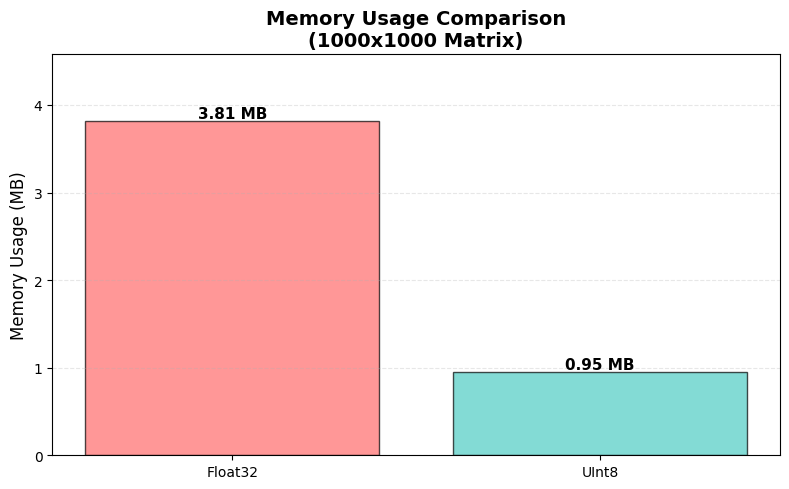


✓ 4x memory reduction achieved!


In [15]:
# Create larger matrices to see memory difference
size = 1000
large_fp32 = np.random.randn(size, size).astype(np.float32)
large_uint8 = np.random.randint(0, 256, (size, size), dtype=np.uint8)

mem_fp32 = large_fp32.nbytes / (1024 * 1024)  # MB
mem_uint8 = large_uint8.nbytes / (1024 * 1024)  # MB

print(f"Matrix size: {size}x{size}")
print(f"\nMemory Usage:")
print(f"  Float32:  {mem_fp32:.2f} MB")
print(f"  UInt8:    {mem_uint8:.2f} MB")
print(f"  Reduction: {mem_fp32/mem_uint8:.2f}x")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
types = ['Float32', 'UInt8']
memory = [mem_fp32, mem_uint8]
colors = ['#ff6b6b', '#4ecdc4']

bars = ax.bar(types, memory, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Memory Usage (MB)', fontsize=12)
ax.set_title(f'Memory Usage Comparison\n({size}x{size} Matrix)', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(memory) * 1.2)

# Add value labels on bars
for bar, val in zip(bars, memory):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f} MB',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n✓ 4x memory reduction achieved!")

## 6. Error Analysis Across Different Scales

Let's analyze how quantization error varies with input magnitude.

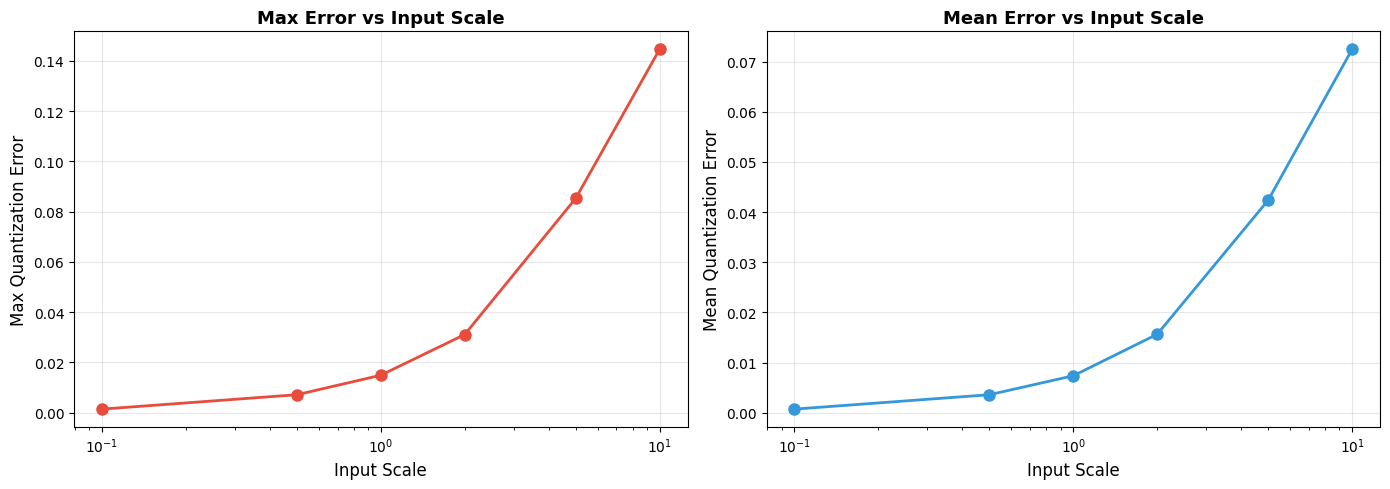


Observation: Quantization error scales proportionally with input magnitude.


In [16]:
# Test quantization error at different scales
scales = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
max_errors = []
mean_errors = []

for scale in scales:
    data = np.random.randn(100, 100).astype(np.float32) * scale
    arr_fp32 = nd.NDArray(data)
    arr_uint8 = arr_fp32.quantize_uint8()
    arr_dequant = arr_uint8.dequantize()
    
    error = np.abs(arr_fp32.numpy() - arr_dequant.numpy())
    max_errors.append(error.max())
    mean_errors.append(error.mean())

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(scales, max_errors, 'o-', linewidth=2, markersize=8, color='#e74c3c')
ax1.set_xlabel('Input Scale', fontsize=12)
ax1.set_ylabel('Max Quantization Error', fontsize=12)
ax1.set_title('Max Error vs Input Scale', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

ax2.plot(scales, mean_errors, 'o-', linewidth=2, markersize=8, color='#3498db')
ax2.set_xlabel('Input Scale', fontsize=12)
ax2.set_ylabel('Mean Quantization Error', fontsize=12)
ax2.set_title('Mean Error vs Input Scale', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

print("\nObservation: Quantization error scales proportionally with input magnitude.")

## 7. Summary

### Key Benefits of UInt8 Quantization:

1. **Memory Efficiency**: 4x reduction (32 bits → 8 bits)
2. **Performance**: Potential speedup from integer arithmetic
3. **Energy Efficiency**: Lower power consumption
4. **Deployment**: Better for edge devices and mobile

### Tradeoffs:

1. **Accuracy Loss**: Small quantization error (typically < 1%)
2. **Limited Range**: 256 discrete values (vs continuous float32)
3. **Implementation**: Requires careful scaling

### When to Use:

- ✓ Inference on edge devices
- ✓ Large model deployment
- ✓ Memory-constrained environments
- ✓ Production inference servers

### When NOT to Use:

- ✗ Training (need high precision gradients)
- ✗ Tasks requiring high numerical precision
- ✗ Small models where memory isn't an issue

## 8. Next Steps

This implementation provides:
- ✓ NDArray-level quantization (quantize_uint8, dequantize, astype)
- ✓ Tensor-level quantization API
- ✓ Quantized matmul for uint8 inputs
- ✓ Quantized Linear layers
- ✓ Automatic dequantization for unsupported ops
- ✓ NumPy backend support

### Future Enhancements:
1. C++/CUDA backend implementations for better performance
2. Per-channel quantization for better accuracy
3. Quantization-aware training (QAT)
4. Dynamic quantization
5. Support for other quantized operations (conv, etc.)
6. Mixed precision (some layers quantized, others not)

---

**Thank you for exploring the UInt8 quantization feature!**